In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from scipy.signal import spectrogram, medfilt

In [2]:
#Block audio function
def  block_audio(x,blockSize,hopSize,fs):
    # allocate memory
    numBlocks = math.ceil(x.size / hopSize)
    xb = np.zeros([numBlocks, blockSize])
    # compute time stamps
    t = (np.arange(0, numBlocks) * hopSize) / fs

    x = np.concatenate((x, np.zeros(blockSize)),axis=0)

    for n in range(0, numBlocks):
        i_start = n * hopSize
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])

        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]

    return (xb,t)

In [3]:
#Hann window function
def compute_hann(iWindowLength):
    return 0.5 - (0.5 * np.cos(2 * np.pi / iWindowLength * np.arange(iWindowLength)))


In [4]:
def compute_spectrogram(xb, fs):
    (NumOfBlocks, blockSize) = xb.shape
    FFT_point = blockSize
    hann = compute_hann(blockSize)

    fInHz, t, X = spectrogram(xb, fs, window=hann, nfft=FFT_point)

    X = np.array(X)
    X = np.squeeze(X, axis=2)
    X = np.transpose(X)

    fInHz = np.array(fInHz)

    return (X, fInHz)

In [9]:
def track_pitch_fftmax(x, blockSize, hopSize, fs):
    (xb, timeInSec) = block_audio(x, blockSize, hopSize, fs)
    (X, fInHz) = compute_spectrogram(xb, fs)

    # get index of max magnitude within each block and the corresponding frequency
    nBlocks = len(timeInSec)
    f0 = np.zeros(nBlocks)
    for block in range(0, nBlocks - 1):
        i = np.argmax(X[:, block])
        f0[block] = fInHz[i]
    return (f0, timeInSec)

In [10]:
#E1. generate a test signal (sine wave, f = 441 Hz from 0-1 sec and f = 882 Hz from 1-2 sec),

fs = 44100
timeA = np.linspace(start=0, stop=1, num=fs, endpoint=False)
timeB = np.linspace(start=1, stop=2, num=fs, endpoint=False)

# generate test signals at 441 Hz from 0 to 1 sec and 882 Hz from 1 to 2 sec
testsignalA = np.sin(2 * np.pi * 441 * timeA)
testsignalB = np.sin(2 * np.pi * 882 * timeB)

# append arrays to create a 2 sec test signal
testSignal = np.append(testsignalA, testsignalB)

In [11]:
#check dimensions of vectors created by functions above 
(xb, timeInSec) = block_audio(x=testSignal, blockSize=1024, hopSize=512, fs=44100)
print('xb shape=',xb.shape)
print('timeInSec shape=',timeInSec.shape)
(X, fInHz) = compute_spectrogram(xb=xb, fs=44100)
print ('X shape=',X.shape)
print('fInHz shape=',fInHz.shape)

xb shape= (173, 1024)
timeInSec shape= (173,)
X shape= (513, 173)
fInHz shape= (513,)


In [12]:
(f0TestMaxPeak,timeTestMaxPeak)=track_pitch_fftmax(x=testSignal,blockSize=1024,hopSize=512,fs=44100)

In [13]:
print('f0TestMaxPeak first few elements',f0TestMaxPeak[0:10])
print('timetestMaxPeak first few elements',timeTestMaxPeak[0:10])

f0TestMaxPeak first few elements [430.6640625 430.6640625 430.6640625 430.6640625 430.6640625 430.6640625
 430.6640625 430.6640625 430.6640625 430.6640625]
timetestMaxPeak first few elements [0.         0.01160998 0.02321995 0.03482993 0.04643991 0.05804989
 0.06965986 0.08126984 0.09287982 0.1044898 ]


In [14]:
max(f0TestMaxPeak)

861.328125

In [15]:
min(f0TestMaxPeak)

0.0

In [16]:
nBlocks=len(timeInSec)
trueF=np.zeros(nBlocks)
for i in range(0,nBlocks-1):
    if timeInSec[i]<1:
        trueF[i]=440
    else:
        trueF[i]=880        

<function matplotlib.pyplot.show(*args, **kw)>

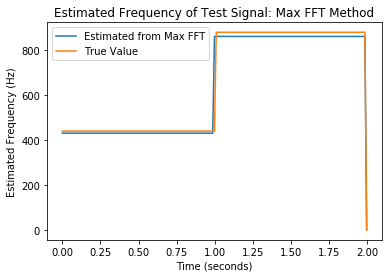

In [17]:
plt.plot(timeInSec,f0TestMaxPeak,label="Estimated from Max FFT")
plt.plot(timeInSec,trueF, label="True Value")
plt.xlabel('Time (seconds)')
plt.ylabel('Estimated Frequency (Hz)')
plt.title('Estimated Frequency of Test Signal: Max FFT Method')
plt.legend()
plt.show   

In [18]:
def audio_read(path):
    samplerate, x = read(path)
    if x.dtype == 'float32':
        audio = x
    else:
        # change range to [-1,1)
        if x.dtype == 'uint8':
            nbits = 8
        elif x.dtype == 'int16':
            nbits = 16
        elif x.dtype == 'int32':
            nbits = 32

        audio = x / float(2**(nbits - 1))

    # special case of unsigned format
    if x.dtype == 'uint8':
        audio = audio - 1.

    if audio.ndim > 1:
        audio = audio[:, 0]

    return samplerate, audio

In [19]:
#test on one file from the training dataset
fs, audio = audio_read('C:/Users/Laney/Documents/6201_comp_mus_analysis/Assignments/Assignment 3/data/traindata/01-D_AMairena.wav')
(f0Mairena,timeMairena)=track_pitch_fftmax(x=audio,blockSize=1024,hopSize=512,fs=fs)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [20]:
#function to read labels from annotation file
def read_label(path, estimateTime):

        es_idx = 0
        pre = -1

        oup = []
        time = []
        f = open(path, "r")
        for x in f:
            time = float(x.split('     ')[0])
            if es_idx < len(estimateTime):
                while es_idx < len(estimateTime) and estimateTime[es_idx] < time and estimateTime[es_idx] > pre:
                    oup.append(x.split('     ')[2])
                    pre = estimateTime[es_idx]
                    es_idx+=1
        return oup

In [21]:
#get annotated data
gtHz = np.array(read_label('C:/Users/Laney/Documents/6201_comp_mus_analysis/Assignments/Assignment 3/data/traindata/01-D_AMairena.f0.Corrected.txt',timeMairena)).astype(np.float)

<function matplotlib.pyplot.show(*args, **kw)>

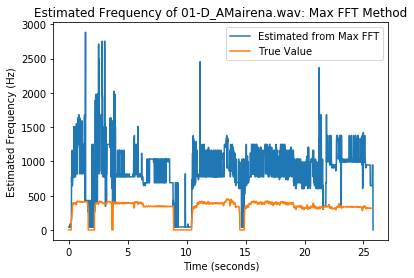

In [22]:
plt.plot(timeMairena,f0Mairena,label="Estimated from Max FFT")
plt.plot(timeMairena,gtHz, label="True Value")
plt.xlabel('Time (seconds)')
plt.ylabel('Estimated Frequency (Hz)')
plt.title('Estimated Frequency of 01-D_AMairena.wav: Max FFT Method')
plt.legend()
plt.show  

In [20]:
#D1. eval_voiced_fp computes the percentage of false positives for the fundamental frequency estimation
def eval_voiced_fp(estimation, annotation):
    #denominator = num blocks with annotation = 0
    denom=(annotation==0).sum()
    n=len(annotation)
    #create a vector to define which blocks in the denominator are also in the numerator (value=1 if it is in the numerator)
    numvector=np.zeros(n)
    for i in range(0,n-1):
        if (annotation[i]==0) & (estimation[i]!=0):
            numvector[i]=1
    #numerator = num blocks in the denominator with fundamental freq not equal to 0
    num=(numvector==1).sum()
    pfp=num/denom
    print('denom (N with annotation=0)=',denom)
    print('num (N with annotation=0 and estimation not 0)=',num)
    print('pfp=',pfp)
    return pfp

#D2. eval_voiced_fn computes the percentage of false negatives
def eval_voiced_fn(estimation, annotation):
    #denominator = num blocks with non-zero fundamental frequency in the annotation.
    denom=(annotation!=0).sum()
    n = len(annotation)
    # create a vector to define which blocks in the denominator are also in the numerator (value=1 if in the numerator)
    numvector = np.zeros(n)
    for i in range(0, n - 1):
        if (annotation[i] != 0) & (estimation[i] == 0):
            numvector[i] = 1
    #numerator = num blocks in denominator that were detected as zero
    num=(numvector==1).sum()
    pfn=num/denom
    print('denom (N with annotation not 0)=',denom)
    print('num (N with annotation not 0 and estimation=0)=',num)
    print('pfn=',pfn)
    return pfn

In [21]:
eval_voiced_fn(estimation=f0Mairena,annotation=gtHz)

denom (N with annotation not 0)= 1982
num (N with annotation not 0 and estimation=0)= 0
pfn= 0.0


0.0

In [22]:
eval_voiced_fp(estimation=f0Mairena,annotation=gtHz)

denom (N with annotation=0)= 242
num (N with annotation=0 and estimation not 0)= 242
pfp= 1.0


1.0

In [24]:
(f0Mairena!=0).sum()

2223

In [25]:
(gtHz!=0).sum()

1982

In [26]:
(f0Mairena==0).sum()

1

In [27]:
(gtHz==0).sum()

242

In [28]:
len(f0Mairena)

2224

In [29]:
len(gtHz)

2224

In [30]:
f0Mairena[0:20]

array([43.06640625, 43.06640625, 43.06640625, 43.06640625, 43.06640625,
       43.06640625, 43.06640625, 43.06640625, 43.06640625, 86.1328125 ,
       43.06640625, 43.06640625, 43.06640625, 43.06640625, 43.06640625,
       43.06640625, 43.06640625, 43.06640625, 43.06640625, 86.1328125 ])

In [31]:
gtHz[0:20]

array([  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   , 143.918])